## Importar todas las librerías

In [1]:
from nilearn import plotting
%matplotlib inline
from os.path import join as opj
import os
import json
from nipype.interfaces.fsl import (BET, ExtractROI, FAST, FLIRT, ImageMaths,
                                   MCFLIRT, SliceTimer, Threshold, MELODIC, FilterRegressor)
#from nipype.interfaces.spm import Smooth
from nipype.interfaces.utility import IdentityInterface
from nipype.interfaces.io import SelectFiles, DataSink
from nipype.algorithms.rapidart import ArtifactDetect
from nipype import Workflow, Node, Function
import nibabel as nib
import automaticclassificationcnnFALSE as auto
#Colocar script py en las misma carpeta

/opt/miniconda-latest/envs/neuro/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


## Parametros del conjunto

In [2]:
#Direcciones de trabajo
experiment_dir = '/output'
output_dir = 'datasink'
working_dir = 'workingdir'

# Etiquetas de los sujetoos
subject_list = ['01']#, '02', '03', '04', '05', '06', '07', '08', '09', '10']

# Sesiones 
task_list = ['rest']

# Ancho del suavizado
fwhm = [4, 8]

#Abrir achiivo json para sacar TR
with open('/data/ds000133/sub-01/ses-pre/func/sub-01_ses-pre_task-rest_run-01_bold.json', 'rt') as fp:
    task_info = json.load(fp)
TR = task_info['RepetitionTime']
#TR=2.0

# Isometric resample of functional images to voxel size (in mm)
iso_size = 4

In [3]:
def downloadH5(DIR_F):
    import os
    os.system('wget https://github.com/LxMera/Convolutional-Neural-Network-for-the-classification-of-independent-components-of-rs-fMRI/raw/master/LAYER4-C_COM-Saggital-0.h5 -P '+DIR_F)
    Path=DIR_F+'/LAYER4-C_COM-Saggital-0.h5'
    return Path

In [4]:
CNN_H5=downloadH5(opj(experiment_dir, working_dir))

ANAT='/data/ds000133/sub-01/ses-pre/anat/sub-01_ses-pre_T1w.nii.gz'
FUNC='/data/ds000133/sub-01/ses-pre/func/sub-01_ses-pre_task-rest_run-01_bold.nii.gz'
print(CNN_H5)
print(nib.load(ANAT).shape)
print(nib.load(FUNC).shape)
print(TR)

/output/workingdir/LAYER4-C_COM-Saggital-0.h5
(256, 256, 180)
(64, 64, 30, 145)
1.67065


In [5]:
CNN=auto.get_Layer_4('Sagittal', CNN_H5)

Recibio : Sagittal
Recibio : /output/workingdir/LAYER4-C_COM-Saggital-0.h5


### Funciones propias

In [6]:
def smoothNi(PATH_GZ, fwhm):
    from nilearn import image
    import os

    F_smooth=image.smooth_img(PATH_GZ,fwhm=fwhm)
    OutFile='s'+PATH_GZ[PATH_GZ.rfind('/')+1:]
    F_smooth.to_filename(OutFile)
    
    out_file=os.path.abspath(OutFile)
    return out_file

def filtered(PATH_GZ, Time_R):
    from nilearn.input_data import NiftiMasker
    from nilearn.signal import butterworth
    import os
        
    masker = NiftiMasker()   
    signal = masker.fit_transform(PATH_GZ)    
    X_filtered = butterworth(signals=signal, sampling_rate=1./Time_R, high_pass=0.01, copy=True)
    fmri_filtered = masker.inverse_transform(X_filtered)
    OutFile='f'+PATH_GZ[PATH_GZ.rfind('/')+1:]
    fmri_filtered.to_filename(OutFile)
    
    out_file=os.path.abspath(OutFile)
    return out_file

def SelecICA(in_dir):
    import glob
    mec_mix=glob.glob(in_dir+'/*_mix')[0]    
    return mec_mix

### Nodos del preproceso principal

In [7]:
# Eliminar primeros volumenes
extract = Node(ExtractROI(t_min=4, t_size=-1, output_type='NIFTI'),
               name="extract")

# Correccion de movimiento
mcflirt = Node(MCFLIRT(mean_vol=True,
                       save_plots=True,
                       output_type='NIFTI'),
               name="mcflirt")

# Corrección de tiempo de corte
slicetimer = Node(SliceTimer(index_dir=False,
                             interleaved=True,
                             output_type='NIFTI',
                             time_repetition=TR),
                  name="slicetimer")

smooth=Node(Function(input_names=['PATH_GZ', 'fwhm'],
                     output_names=['out_file'],
                     function=smoothNi),
            name='smooth')

smooth.iterables = ("fwhm", fwhm)

Filter=Node(Function(input_names=['PATH_GZ', 'Time_R'],
                     output_names=['out_file'],
                     function=filtered),
            name='filter')
Filter.inputs.Time_R=TR

# Deteccion de Artefa- determines outliers in functional images
art = Node(ArtifactDetect(norm_threshold=2,
                          zintensity_threshold=3,
                          mask_type='spm_global',
                          parameter_source='FSL',
                          use_differences=[True, False],
                          plot_type='svg'),
           name="art")

### Nodos del coregistro

In [8]:
# Eliminar craneo
bet_anat = Node(BET(frac=0.5,
                    in_file = ANAT,
                    robust=True,
                    output_type='NIFTI_GZ'),
                name="bet_anat")

# Segmentacion LCR, MG y MB
segmentation = Node(FAST(output_type='NIFTI_GZ'),
                name="segmentation")

# Selecionar el archivo de MB desde la salida de la segmentacion
def get_wm(files):
    return files[-1]

# Umbralizacion - Imagen de probabilidad de la MB umbralizada
threshold = Node(Threshold(thresh=0.5,
                           args='-bin',
                           output_type='NIFTI_GZ'),
                name="threshold")

# Pre realineacion de la imagenes funcionales a la imagenes anatomicas
coreg_pre = Node(FLIRT(dof=6, output_type='NIFTI_GZ'),
                 name="coreg_pre")

# FLIRT - coregistration de la imagen funcional a la imagen anatomica con BBR (
# BBR (Basado en los límintes de la materia blanca)
# El corregistro se centra en corregir el movimiento entre sus exploraciones anatómicas
# y sus exploraciones funcionales
coreg_bbr = Node(FLIRT(dof=6,
                       cost='bbr',
                       schedule=opj(os.getenv('FSLDIR'),
                                    'etc/flirtsch/bbr.sch'),
                       output_type='NIFTI_GZ'),
                 name="coreg_bbr")

# Aplicar la transformacion del coregistro a la imagen funcional
applywarp = Node(FLIRT(interp='spline',
                       apply_isoxfm=iso_size,
                       output_type='NIFTI'),
                 name="applywarp")

# Aplicar la transformacion del coregistro a los archivos promedios
applywarp_mean = Node(FLIRT(interp='spline',
                            apply_isoxfm=iso_size,
                            output_type='NIFTI_GZ'),
                 name="applywarp_mean")

In [9]:
# Crear el flujo de trabajo del coregistro
coregwf = Workflow(name='coregwf')
coregwf.base_dir = opj(experiment_dir, working_dir)

In [10]:
# Conectar todos los Nodos del flujo
coregwf.connect([(bet_anat, segmentation, [('out_file', 'in_files')]),
                (segmentation, threshold, [(('partial_volume_files', get_wm), 'in_file')]),
                 (bet_anat, coreg_pre, [('out_file', 'reference')]),
                 (threshold, coreg_bbr, [('out_file', 'wm_seg')]),
                 (coreg_pre, coreg_bbr, [('out_matrix_file', 'in_matrix_file')]),
                 (coreg_bbr, applywarp, [('out_matrix_file', 'in_matrix_file')]),
                 (bet_anat, applywarp, [('out_file', 'reference')]),
                 (coreg_bbr, applywarp_mean, [('out_matrix_file', 'in_matrix_file')]),
                 (bet_anat, applywarp_mean, [('out_file', 'reference')]),
                 ])

200327-21:28:04,173 nipype.workflow INFO:
	 Generated workflow graph: /output/workingdir/coregwf/graph.png (graph2use=flat, simple_form=True).


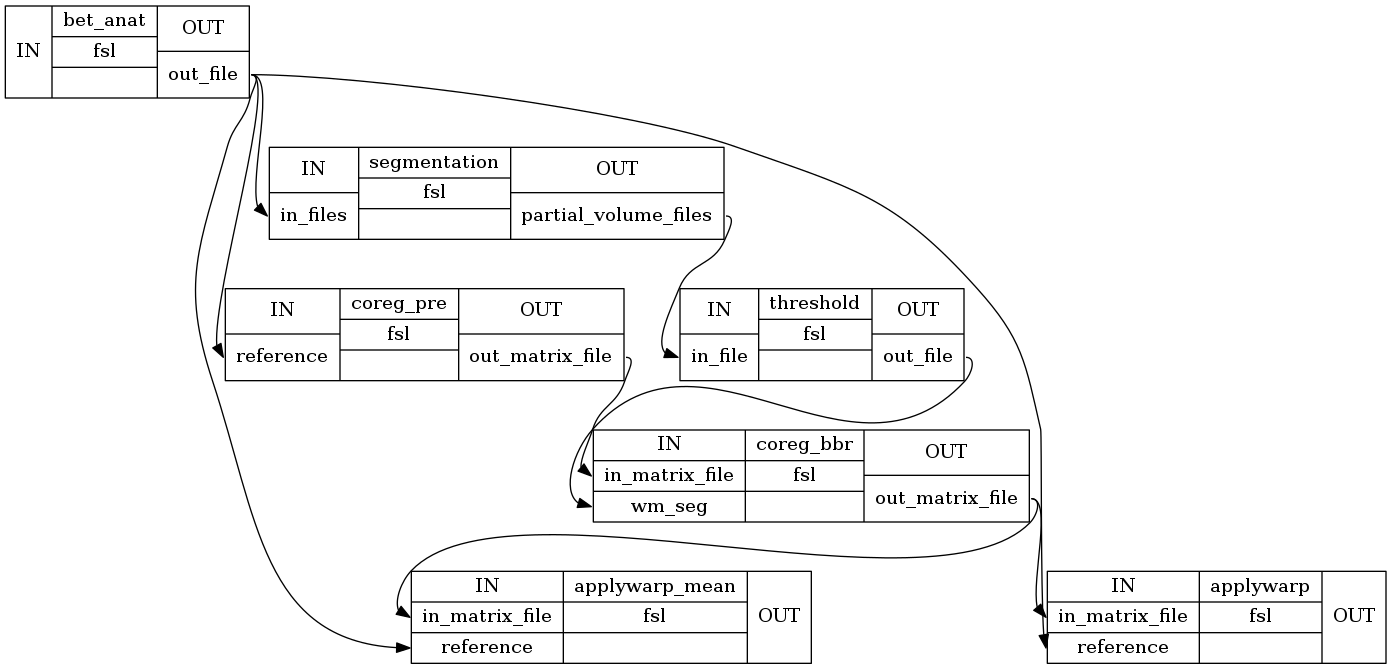

In [11]:
#Visualizar el flujo de trabajo
coregwf.write_graph(graph2use='flat')
from IPython.display import Image
Image(filename="/output/workingdir/coregwf/graph_detailed.png")

### Especificar entradas y salidas del flujo

In [12]:
#Informacion de la fuente: Un nodo para iterar entre todos los suujetos 
infosource = Node(IdentityInterface(fields=['subject_id', 'task_name']),
                  name="infosource")

#Iteracion entre sujetos y las tareas de los sujetos
infosource.iterables = [('subject_id', subject_list),
                        ('task_name', task_list)]

# Estructura de los nombre de los sujetos
anat_file = opj('sub-{subject_id}', 'ses-pre', 'anat','sub-{subject_id}_ses-pre_T1w.nii.gz')
func_file = opj('sub-{subject_id}', 'ses-pre', 'func','sub-{subject_id}_ses-pre_task-{task_name}_run-01_bold.nii.gz')

#Archivos anatomicos y funcionales
templates = {'anat': anat_file,
             'func': func_file}

#Nodo de direccion de los sujetos
selectfiles = Node(SelectFiles(templates,
                               base_directory='/data/ds000133'),
                   name="selectfiles")

# Datasink - Crear una carpeta de salidad para almacenar las entradas
datasink = Node(DataSink(base_directory=experiment_dir,
                         container=output_dir),
                name="datasink")

## Use the following DataSink output substitutions
## Los archivos generados tienen esas palabras claves en sus direcciones
## Por lo tanto se cambian esas palabras por las otras para que queden en
## el formato establecido

substitutions = [('_subject_id_', 'sub-'),  #sub-01     Carpeta por sujeto
                 ('_task_name_', '/task-'), #task-rest  Carpeta de tareas
                 ('_fwhm_', 'fwhm-'),       #Variacion en el fwhm
                 ('_roi', ''),              #segunto argumento vacio
                 ('_mcf', ''),              #''
                 ('_st', ''),               #''
                 ('_flirt', ''),            #''
                 ('.nii_mean_reg', '_mean'),
                 ('.nii.par', '.par'),
                 ]
#Se buscan subcarpetas para eliminarlas
subjFolders = [('fwhm-%s/' % f, 'fwhm-%s_' % f) for f in fwhm]

# Se crean los pares de nombres de "/" a "-"
# Esto permite pasar de un sub caparpeta a un archivo directo
# y se agrega a los pares de sustituciones
substitutions.extend(subjFolders)

# Se indican las sustituciones en los direcciones y nombres al NODO
datasink.inputs.substitutions = substitutions

### Nodos denoising

In [13]:
ICA = Node(MELODIC(report = True, ),
                  name="Descomposition_ICA")

Selec=Node(Function(input_names=['in_dir'],
                    output_names=['melodic_mix'],
                    function=SelecICA),
           name='Selection_files')

Auto_CNN=Node(Function(input_names=['SUB', 'mod'],
                    output_names=['noise', 'typeOfIC'],
                    function=auto.classificationIC_by_CNN),
           name='Classification')
Auto_CNN.inputs.mod=CNN

D_ICA=Node(FilterRegressor(),
            name='Denoising_ICA')

## Flujo completo

In [14]:
# Create a preprocessing workflow
preproc = Workflow(name='preproc')
preproc.base_dir = opj(experiment_dir, working_dir) #Une los caracteres con un /

# Connect all components of the preprocessing workflow
preproc.connect([(infosource, selectfiles, [('subject_id', 'subject_id'),     ('task_name', 'task_name')]),
                 (selectfiles, extract, [('func', 'in_file')]),
                 (extract, mcflirt, [('roi_file', 'in_file')]),
                 (mcflirt, slicetimer, [('out_file', 'in_file')]),

                 (selectfiles, coregwf, [('anat', 'bet_anat.in_file'),
                                         ('anat', 'coreg_bbr.reference')]),
                 (mcflirt, coregwf, [('mean_img', 'coreg_pre.in_file'),
                                     ('mean_img', 'coreg_bbr.in_file'),
                                     ('mean_img', 'applywarp_mean.in_file')]),
                 (slicetimer, coregwf, [('slice_time_corrected_file', 'applywarp.in_file')]),
                 
                 #(coregwf, smooth, [('applywarp.out_file', 'in_files')]),
                 (coregwf, art, [('applywarp.out_file', 'realigned_files')]),
                 (mcflirt, art, [('par_file', 'realignment_parameters')]),
                 (coregwf, smooth, [('applywarp.out_file', 'PATH_GZ')]),
                 (smooth, Filter, [('out_file', 'PATH_GZ')]),
                 
                 (Filter, ICA, [("out_file", "in_files")]),
                 (ICA, Selec, [("out_dir", "in_dir")]),
                 (Filter, D_ICA, [("out_file", "in_file")]),
                 (Selec, D_ICA, [("melodic_mix", "design_file")]),
                 (ICA, Auto_CNN,[("out_dir", "SUB")]),
                 (Auto_CNN, D_ICA,[("noise", "filter_columns")]),
                                 
                 #Organizar los datos de salida
                  #Nombre del nodo
                 (D_ICA, datasink, [('out_file', 'preproc.@Denoising')]),
                 (mcflirt, datasink, [('par_file', 'preproc.@par')]),                 
                 (coregwf, datasink, [('applywarp_mean.out_file', 'preproc.@mean')]),
                 (coregwf, datasink, [('coreg_bbr.out_matrix_file', 'preproc.@mat_file'),
                                      ('bet_anat.out_file', 'preproc.@brain')]),
                 (art, datasink, [('outlier_files', 'preproc.@outlier_files'),
                                  ('plot_files', 'preproc.@plot_files')])
                 ])

200327-21:28:04,735 nipype.workflow INFO:
	 Generated workflow graph: /output/workingdir/preproc/graph.png (graph2use=colored, simple_form=True).


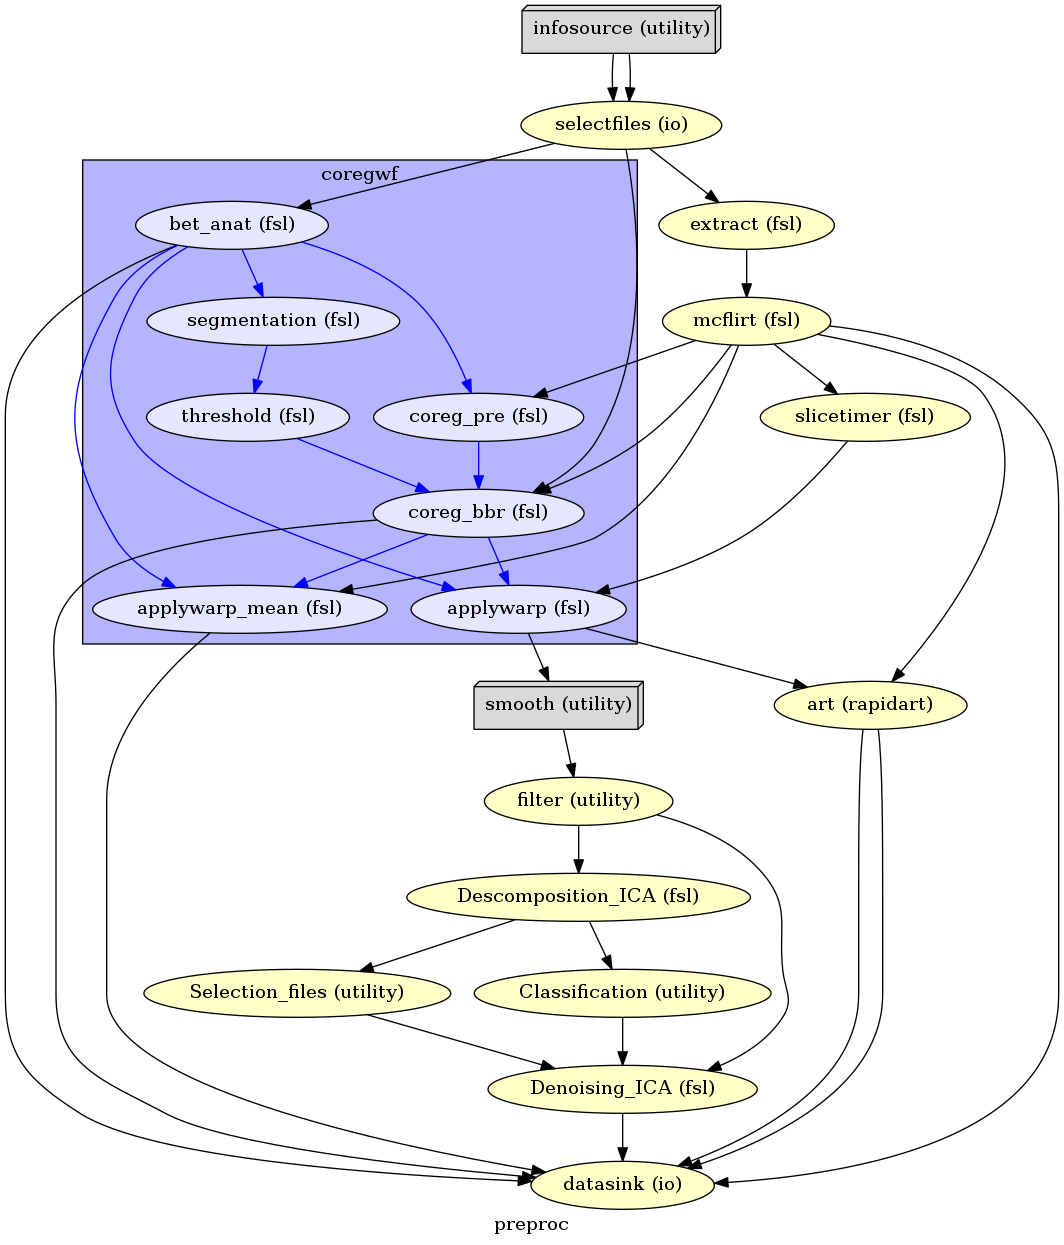

In [15]:
# Create preproc output graph
preproc.write_graph(graph2use='colored', format='png', simple_form=True)

# Visualize the graph
from IPython.display import Image
Image(filename=opj(preproc.base_dir, 'preproc', 'graph.png'))

200327-21:28:05,536 nipype.workflow INFO:
	 Generated workflow graph: /output/workingdir/preproc/graph.png (graph2use=flat, simple_form=True).


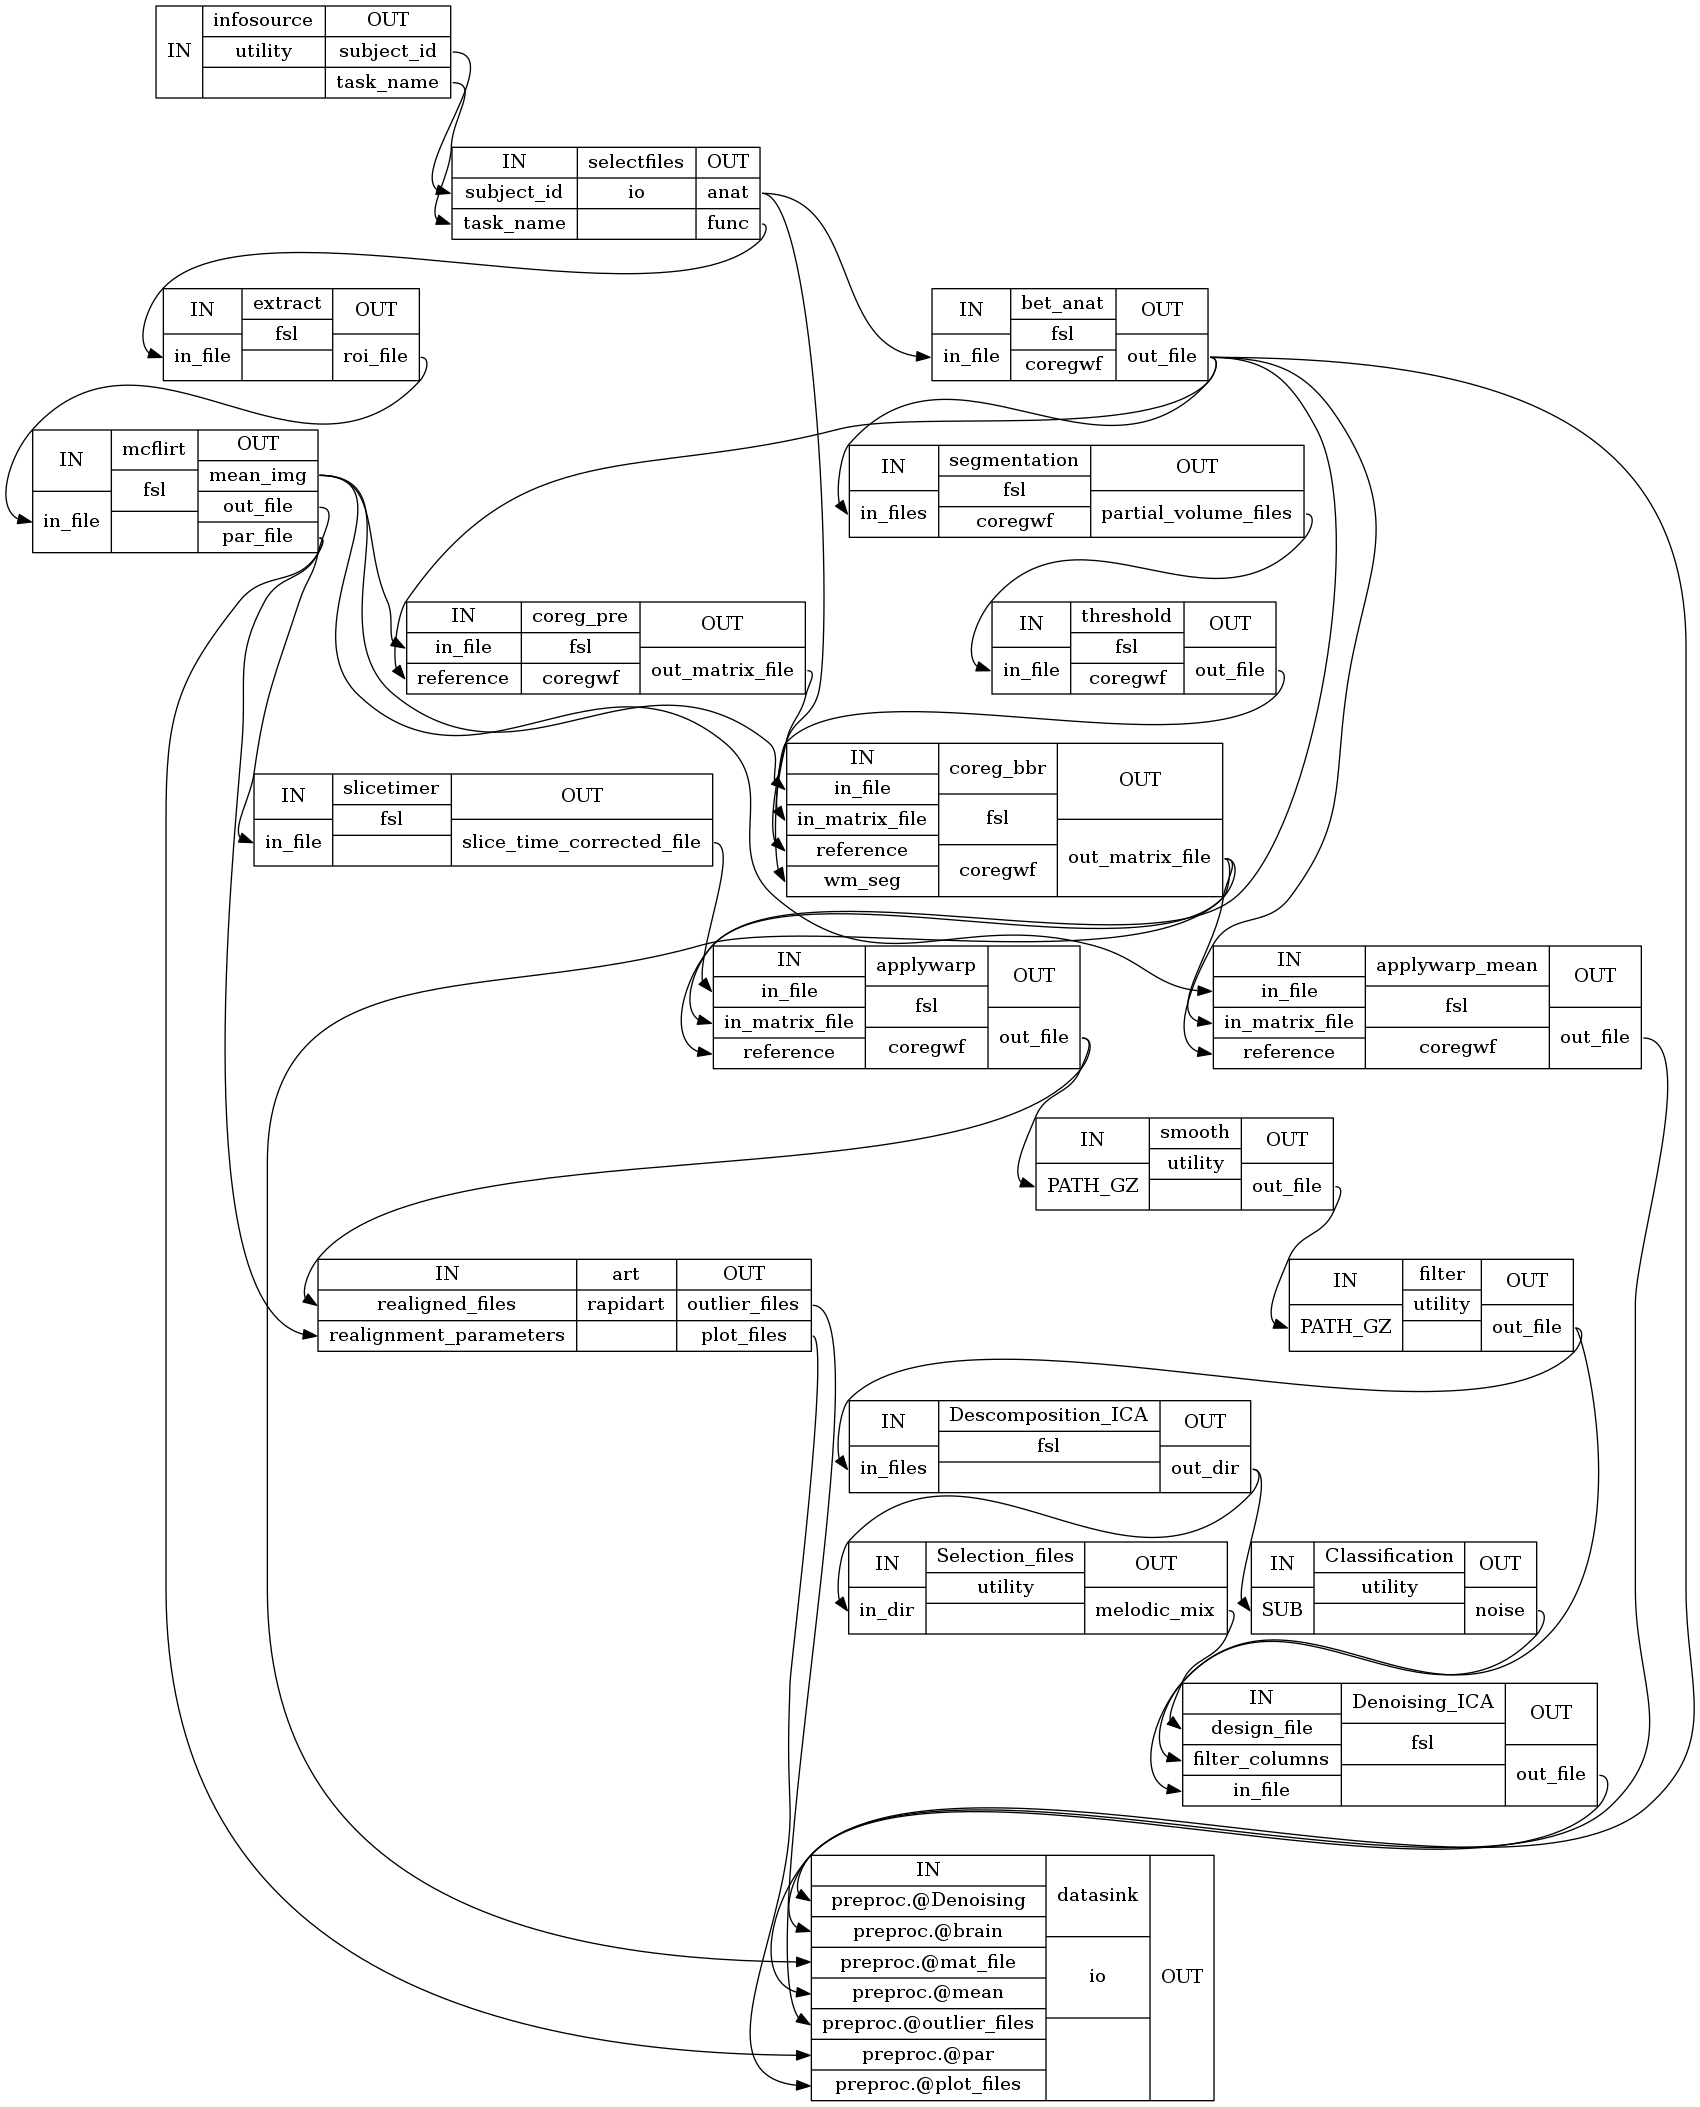

In [16]:
preproc.write_graph(graph2use='flat', format='png', simple_form=True)
Image(filename=opj(preproc.base_dir, 'preproc', 'graph_detailed.png'))

In [ ]:
preproc.run('MultiProc', plugin_args={'n_procs': 4})

200327-21:28:05,783 nipype.workflow INFO:
	 Workflow preproc settings: ['check', 'execution', 'logging', 'monitoring']
200327-21:28:05,870 nipype.workflow INFO:
	 Running in parallel.
200327-21:28:05,878 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 1 jobs ready. Free memory (GB): 6.79/6.79, Free processors: 4/4.
200327-21:28:06,26 nipype.workflow INFO:
	 [Node] Setting-up "preproc.selectfiles" in "/output/workingdir/preproc/_subject_id_01_task_name_rest/selectfiles".
200327-21:28:06,69 nipype.workflow INFO:
	 [Node] Running "selectfiles" ("nipype.interfaces.io.SelectFiles")
200327-21:28:06,89 nipype.workflow INFO:
	 [Node] Finished "preproc.selectfiles".
200327-21:28:07,883 nipype.workflow INFO:
	 [Job 0] Completed (preproc.selectfiles).
200327-21:28:07,898 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 2 jobs ready. Free memory (GB): 6.79/6.79, Free processors: 4/4.
200327-21:28:08,41 nipype.workflow INFO:
	 [Job 1] Cached (preproc.coregwf.bet_anat).
200327-21:28

## Inspect output

Let's check the structure of the output folder, to see if we have everything we wanted to save.

In [ ]:
!tree /output/datasink/preproc

## Visualize results

Let's check the effect of the different smoothing kernels.

In [ ]:
from nilearn import image, plotting
out_path = '/output/datasink/preproc/sub-01/task-rest'

In [ ]:
plotting.plot_epi(
    '/data/ds000133/sub-01/ses-pre/anat/sub-01_ses-pre_T1w.nii.gz',
    title="T1", display_mode='ortho', annotate=False, draw_cross=False, cmap='gray');

In [ ]:
plotting.plot_epi(opj(out_path, 'sub-01_ses-pre_task-rest_run-01_bold_mean.nii.gz'),
                  title="fwhm = 0mm", display_mode='ortho', annotate=False, draw_cross=False, cmap='gray');

In [ ]:
plotting.plot_epi(image.mean_img(opj(out_path, 'fwhm-4_ssub-01_ses-pre_task-rest_run-01_bold.nii')),
                  title="fwhm = 4mm", display_mode='ortho', annotate=False, draw_cross=False, cmap='gray');

In [ ]:
plotting.plot_epi(image.mean_img(opj(out_path, 'fwhm-8_ssub-01_ses-pre_task-rest_run-01_bold.nii')),
                  title="fwhm = 8mm", display_mode='ortho', annotate=False, draw_cross=False, cmap='gray');

Movimiento del sujeto

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
par = np.loadtxt('/output/datasink/preproc/sub-01/task-rest/sub-01_ses-pre_task-rest_run-01_bold.par')
fig, axes = plt.subplots(2, 1, figsize=(15, 5))
axes[0].set_ylabel('Rotación (radians)')
axes[0].plot(par[0:, :3])
axes[1].plot(par[0:, 3:])
axes[1].set_xlabel('Tiempo (TR)')
axes[1].set_ylabel('Traslacion (mm)');

There seems to be a rather drastic motion around volume 102. Let's check if the outliers detection algorithm was able to pick this up.

In [ ]:
import numpy as np
outlier_ids = np.loadtxt('/output/datasink/preproc/sub-01/task-rest/art.sub-01_ses-pre_task-rest_run-01_bold_outliers.txt')
print('Se detectaron valores atipicos en los volumenes: %s' % outlier_ids)

from IPython.display import SVG
SVG(filename='/output/datasink/preproc/sub-01/task-rest/plot.sub-01_ses-pre_task-rest_run-01_bold.svg')